## Comparison of cohesin loop intensities between G1 and metaphasic cells

In this notebook, we demonstrate how `chromosight quantify` can be used to compare chromatin loops between _S. cerevisiae_ cultures arrested in G1 phase vs metaphase. In this notebook, we re-analyse data from [Garcia-Luis, J., Lazar-Stefanita, L., Gutierrez-Escribano, P. et al., 2019](https://doi.org/10.1038/s41594-019-0307-x).

### Input data:

Files used in this analysis are the output from `chromosight quantify`. Loop scores were computed on all 2-way combinations from a set of high confidence RAD21 binding sites separated by 10 to 50kb, on two Hi-C datasets at 2kb resolution: One with G1-arrested cells and the other with metaphase-arrested cells.

* `g1_AT291_2kb.cool`: Hi-C matrix of G1 cells, at 2kb resolution.
* `metaphase_AT198_2kb.cool`: Hi-C matrix of metaphasic cells, at 2kb resolution.
* `rad21.bed2d`: bed file containing all pairs of positions of RAD21 (cohesin) peaks in _S. cerevisiae_ separated by 10-50kb.

> Note: see the end of this notebook for an explanation on how to generate a bed2d file from a ChIP-seq bed file.





### Getting loop scores

Loop scores are all pairs of positions can be computed using `chromosight quantify`. However, to ensure scores are comparable, the number of contacts should be similar between matrices. When using cool files, cooler can be used for this operation:

```bash
$ cooler info metaphase_AT198_2kb.cool | grep sum
"sum": 17950931

$ cooler info g1_AT291_2kb.cool | grep sum
"sum": 22724581
```

> Note: If you are working with bedgraph2 matrices, total contacts can be computed by summing the last column (i.e. contacts). For example, with awk: `awk '{tot=tot+$NF}END{print tot}' matrix.bg2`

The G1 matrix has around 23M contacts whereas the metaphase matrix has 18M. Fortunately, chromosight has a `--subsample` option, which can be used to bring the G1 matrix down to 18M contacts before computing scores:

```bash
chromosight quantify --pattern loops \
                     --subsample 17950931 \
                     --win-fmt npy \
                     rad21.bed2d \
                     g1_AT291_2kb.cool \
                     quantify/rad21_g1

chromosight quantify --pattern loops \
                     --win-fmt npy \
                     rad21.bed2d \
                     metaphase_AT198_2kb.cool \
                     quantify/rad21_metaphase
```

For each condition, `chromosight quantify` generates 2 files:

* `loops_quant.txt`: A table containing the coordinates and pattern matching scores of all input coordinates.
* `loops_quant.npy`: A numpy binary file containing a stack of images around the input coordinates. Those images are stored in the same order as the coordinates from `loops_quant.txt`.

```
quantify/
  ├── rad21_g1
  │   ├── loops_quant.npy
  │   └── loops_quant.txt
  └── rad21_metaphase
      ├── loops_quant.npy
      └── loops_quant.txt
```

### Analysing loop scores

We can now use python to load and compare results from chromosight quantify. Below are a series of analyses showing some examples of downstream processing that can be performed on chromosight results.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import chromosight.kernels as ck
import scipy.stats as st
import seaborn as sns

res = 2000

# Load images (vignettes) around RAD21 interactions coordinates
images_g = np.load('quantify/rad21_g1/loops_quant.npy')
images_m = np.load('quantify/rad21_metaphase/loops_quant.npy')

# Load lists of RAD21 interactions coordinates with their loop scores
# Compute loop size (i.e. anchor distance) for each RAD21 combination
get_sizes = lambda df: np.abs(df.start2 - df.start1)
loops_g = pd.read_csv('quantify/rad21_g1/loops_quant.txt', sep='\t')
loops_g['loop_size'] = get_sizes(loops_g)
loops_m = pd.read_csv('quantify/rad21_metaphase/loops_quant.txt', sep='\t')
loops_m['loop_size'] = get_sizes(loops_m)

# Merge data from both conditions into a single table
loops_g['condition'] = 'g1'
loops_m['condition'] = 'metaphase'
loops_df = pd.concat([loops_g, loops_m]).reset_index(drop=True)
images = np.concatenate([images_g, images_m])

# Remove NaN scores (e.g. in repeated regions or overlap the matrix edge)
nan_mask = ~np.isnan(loops_df['score'])
loops_df = loops_df.loc[nan_mask, :]
images = images = images[nan_mask, :, :]

# The loop kernel can be loaded using chromosight.kernels.loops
kernel = np.array(ck.loops['kernels'][0])
pileup_kw = {'vmin': -1, 'vmax': 1, 'cmap': 'seismic'}

### Peeking at the detected patterns
Images around RAD21 sites 2-way combinations extracted by chromosight can be viewed using numpy and matplotlib.
Note there are series off overlapping and slightly shifted images. This is because of adjacent RAD21 sites which are closer in the genome than the size of the vignettes.

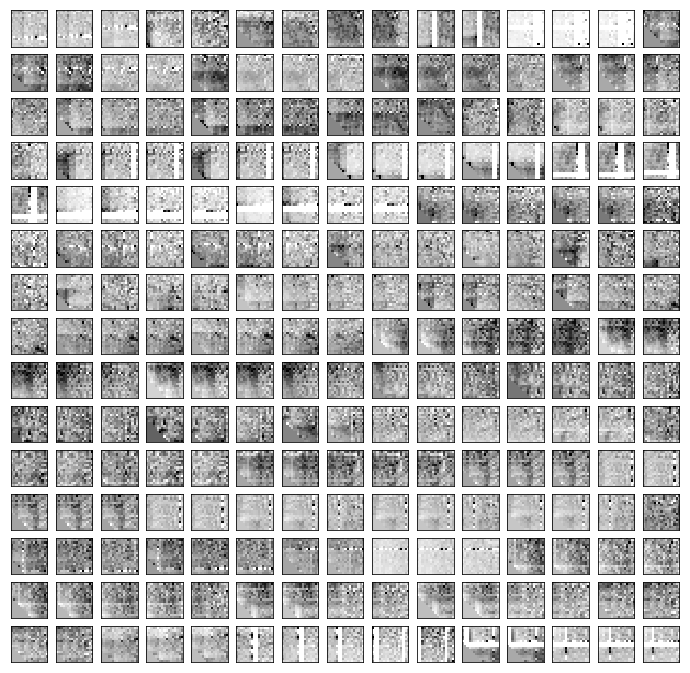

In [5]:
%matplotlib inline
# Decide how many rows and columns of images to show
r = c = 15
fig, axes = plt.subplots(r, c, figsize=(12, 12), subplot_kw={'xticks':[], 'yticks':[]})
# Show each image as a greyscale vignette
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i, :, :], cmap=plt.cm.gray_r, interpolation='nearest')

### Comparing the distribution of scores
The distribution of chromosight scores (i.e. correlation coefficients with the loop kernel) can be compared between the 2 conditions, revealing that metaphasic cells tend to have stronger loops.

Text(0.5, 1.0, 'Comparison of loop scores between G1 and metaphasic cells')

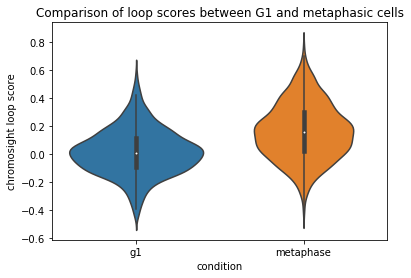

In [6]:
sns.violinplot(data=loops_df, x='condition', y='score')
plt.ylabel('chromosight loop score')
plt.title('Comparison of loop scores between G1 and metaphasic cells')

### Using different metrics
Chromosight scores loops using their pearson correlation with a "loop kernel" (see below). However, one might want to use another metric than chromosight's score to rank loops.

Text(0.5, 1.0, "Chromosight's loop kernel")

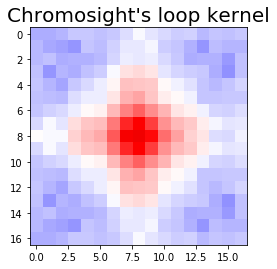

In [7]:
plt.imshow(np.log(kernel), **pileup_kw)
plt.title("Chromosight's loop kernel", size=20)

For example, the 'corner score' defined below could be used. It computes the difference between the sum of contacts in the center and top right corner. It is better this particular corner to avoid corner contacts enrichments for due to the diagonal. This is a pretty intuitive metric tailored based on expectations we have about loops.

In [8]:
def corner_score(pileup, prop_radius=0.2):
    """
    Compute a loop intensity score from a pileup
    
    Parameters
    ----------
    pileup : numpy.array of floats
        2D array representing a pileup window.
    prop_radius : float
        Proportion of image radius used when selecting
        center and corner contacts.
    
    Returns
    -------
    float :
        Corner score, defined as sum(center) - sum(corner).
    """
    n, m = pileup.shape
    center = int(prop_radius * n)
    half_h = n // 2
    half_w = m // 2
    le = half_h - center
    ri = half_h + center + 1
    hi = half_w - center
    lo = half_w + center + 1
    center_sum = pileup[hi:lo, le:ri].sum()
    top_right_sum = pileup[:hi, ri:].sum()
    return round(center_sum - top_right_sum, 2)

This homemade corner score is actually well correlated with chromosight's pearson score:

Text(0.5, 1.0, 'Correlation between chromosight and corner score, $\\rho$: 0.76')

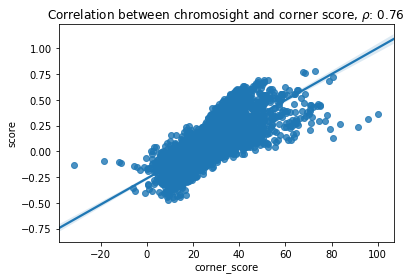

In [9]:
import scipy.stats as st
loops_df['corner_score'] = [corner_score(m) for m in images]
sns.regplot(data=loops_df, x='corner_score', y='score')
plt.title(
    r'Correlation between chromosight and corner score, $\rho$: '
    f'{np.round(st.pearsonr(loops_df.corner_score, loops_df.score)[0], 2)}')

By computing the pileup (average) of all patterns separately for G1 and M conditions, we can visually appreciate the stronger loop signal in metaphasic cells (M) compared to G1. Computing the chromosight and corner score directly on those pileups shows that the chromosight score makes it easier to discriminate the two conditions. The [-1,1] range is also convenient to interpret results. Note that the chromosight score below is just the pearson coefficient of the pileup with the loop kernel.

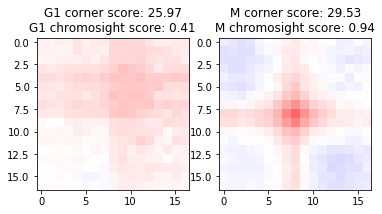

In [10]:
centroid_g1 = np.apply_along_axis(np.nanmean, 0, images[loops_df.condition == 'g1'])
centroid_m = np.apply_along_axis(np.nanmean, 0, images[loops_df.condition == 'metaphase'])

fig, ax = plt.subplots(1, 2)
ax[0].imshow(np.log(centroid_g1), **pileup_kw)
ax[0].set_title(
    f'G1 corner score: {corner_score(centroid_g1)}\n'
    f'G1 chromosight score: {np.round(st.pearsonr(centroid_g1.flat, kernel.flat)[0], 2)}'
)
ax[1].imshow(np.log(centroid_m), **pileup_kw)
ax[1].set_title(
    f'M corner score: {corner_score(centroid_m)}\n'
    f'M chromosight score: {np.round(st.pearsonr(centroid_m.flat, kernel.flat)[0], 2)}'
)
plt.show()

Instead of summarizing the 2 conditions using only pileups, we can compare the ability of both score to separate the G1 and metaphasic cells based on the distribution of all patterns. Note that both scores are z-transformed to make their ranges comparable.

Text(0.5, 1.0, 'Discriminative powe: chromosight vs corner score')

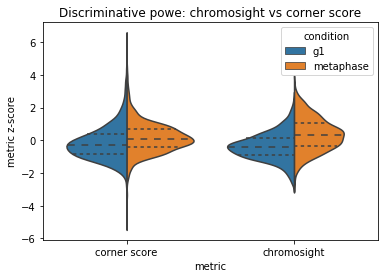

In [11]:
corner = loops_df.drop('score', axis=1).rename(columns={'corner_score': 'score'})
corner['metric'] = 'corner score'
corner['score'] = st.zscore(corner['score'])
chromo = loops_df.drop('corner_score', axis=1)
chromo['metric'] = 'chromosight'
chromo['score'] = st.zscore(chromo['score'])
comp_scores = pd.concat([corner, chromo]).reset_index(drop=True)
sns.violinplot(data=comp_scores, x='metric', y='score', split=True, hue='condition', inner='quartile')
plt.ylabel('metric z-score')
plt.title('Discriminative powe: chromosight vs corner score')

### Comparison of loop footprints
For vizualisation purposes, each window can be summarized to a 1D band representing the sum of columns or rows. Here, we compute both the average of rows and columns, and use the element-wise average of both 1D vectors. This gives a good approximation of a 'loop footprint' and is convenient for visualisation.

Each image is centered to its mean to homogenize the overall contact counts in windows. This avoid having globally darker or lighter images and emphasizes relative contrasts within the images.

Bands are then sorted by loop size (i.e. distance between anchors) and plotted as a stack from shortest to longest distance interactions.

Text(0.5, 0.98, 'Loop bands for pairs of RAD21 sites')

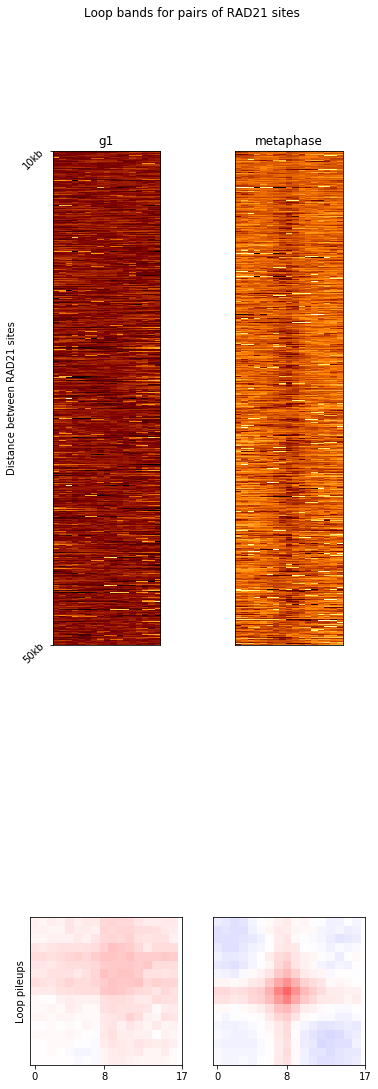

In [12]:
# Center images by subtracting their mean
centered = images.copy()
for img in range(centered.shape[0]):
    centered[img] -= np.mean(centered[img])

# Summarise each image by taking the average of its row and col sums.
bands = (centered.sum(axis=1) + centered.sum(axis=2)) / 2


# Reorder bands by distance between anchors
sort_var = 'loop_size'
sorted_bands = bands[np.argsort(loops_df[sort_var]), :]
sorted_cond = loops_df.condition.iloc[np.argsort(loops_df[sort_var])]
sorted_centered = centered[np.argsort(loops_df[sort_var])]

# Define a subset to visualise (too many images so see them all at once)
#smallest_group = np.min(np.unique(sorted_cond, return_counts=True)[1])-1
#smallest_group = 500

# Define saturation threshold for the colormaps
vmax_bands = np.percentile(bands, 99.9)
vmax_img = np.percentile(centered, 99)

fig, axes = plt.subplots(2, 2, figsize=(6, 20))
for i, cond in enumerate(['g1', 'metaphase']):
    axes[0, i].imshow(sorted_bands[sorted_cond == cond, :], cmap='afmhot_r', vmax=vmax_bands, aspect=0.2)
    axes[0, i].set_title(cond)
    axes[0,i].set_aspect(0.04)
    # Compute pileup by averaging all windows for each condition
    centroid = np.apply_along_axis(np.nanmean, 0, images[loops_df.condition == cond])
    axes[1, i].imshow(np.log(centroid), **pileup_kw)
    
    # The rest is just to improve figure aesthetics
    axes[0, i].set_xticks([])
    axes[1, i].set_yticks([])
    if i > 0:
        axes[0, i].set_yticks([])
    else:
        #axes[0, i].set_yticklabels([], ["10kb", "25kb", "50kb"])
        axes[0, i].set_yticks([0, sorted_bands[sorted_cond == cond, :].shape[0]])
        axes[0, i].set_yticklabels(['10kb', '50kb'], minor=False, rotation=45)
    
    axes[1, i].set_xticks([0, centroid.shape[0] // 2, centroid.shape[0]])
    half_w = int((res * centroid.shape[0] // 2) / 1000)
    half_w_bp = int(half_w * res / 1000)
    axes[1, i].set_yticklabels([f"{-half_w_bp}kb", "0", f"{half_w_bp}kb"])
    #axes[1, i].set_title(f"corner score: {np.round(corner_score(centroid), 2)}")

axes[0, 0].set_ylabel('Distance between RAD21 sites')
axes[1, 0].set_ylabel('Loop pileups')
plt.suptitle(f'Loop bands for pairs of RAD21 sites')
#plt.savefig('figs/bands_pileup_prots.svg')

### Appendix: Generating a BED2D file

ChIP-seq peaks are often stored as BED files, containing genomic intervals where DNA-binding proteins are enriched. Such files can be used to generate a BED2D file for `chromosight quantify`. This is done by generating all possible 2-ways combinations of peaks that follow desired criteria. In the example below, we use python generate all intrachromosomal combinations where peaks are separated by more than 10kb and less than 50kb.

```python
import itertools as it
import pandas as pd
import numpy as np

df=pd.read_csv('rad21_summits.bed', header=None, sep="\t")
out_handle = open('rad21.bed2d', "w+")
# Generate all intrachromosomal combinations
for chrom in np.unique(df[0]):
  chrom_df = df.loc[df[0] == chrom, :]
  for i1, i2 in it.combinations(range(chrom_df.shape[0]),2):
    start1, end1 = chrom_df.iloc[i1, [1, 2]]
    start2, end2 = chrom_df.iloc[i2, [1, 2]]
    dist = np.abs(start2 - start1)
    # Only write the entry if the distance is within acceptable range
    if dist < 50000 and dist > 10000:
      out_handle.write(f'{chrom}\t{start1}\t{end1}\t{chrom}\t{start2}\t{end2}\n')
out_handle.close()  

```